In [1]:
from transformers import AutoTokenizer
from constants import MODEL
from siamese_sbert import SiameseSBERT
from lila_dataset import LILADataset
import torch
import torch.nn.functional as F
import os
from constants import P1, P2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.ticker as mtick

In [2]:
# Parallelization/Concurency
# Use CUDA if available, else use MPS if available. Fallback is CPU
device = torch.device("cuda" if torch.cuda.is_available()
                      else (
                        "mps"
                        if torch.backends.mps.is_available()
                        else "cpu"
                      ))

In [3]:
dataset_path = '../data/normalized'
undistorted_path = os.path.join(dataset_path, 'undistorted')
assert os.path.exists(undistorted_path)
metadata_path = os.path.join(dataset_path, 'metadata.csv')
assert os.path.exists(metadata_path)

# Create list to store all views to process
views = [undistorted_path]

for view_dir in os.listdir(dataset_path):
    view_path = os.path.join(dataset_path, view_dir)
    if view_dir != 'undistorted' and\
       os.path.isdir(view_path) and\
       view_dir[0] != '.':
        assert view_dir[:8] == 'DV-SA-k-' or view_dir[:8] == 'DV-MA-k-'
        views.append(view_path)

view_preds = {}
view_embeddings = {}
for view_path in views:
    # Get simple view string
    # Adapted from:
    # https://stackoverflow.com/a/3925147
    view = os.path.basename(os.path.normpath(view_path))
    # Add an entry to view_preds to store predictions for this
    # particular view
    view_preds[view] = []
    view_embeddings[view] = []

    # Reset any existing splits
    LILADataset.reset_splits()

    # Instantiate the inference dataset
    inference_dataset = LILADataset(view_path,
                                    metadata_path,
                                    cnk_size=512,
                                    num_pairs=0,
                                    seed=0,
                                    letters=True)

    # Load model
    model = SiameseSBERT(MODEL, device).to(device)
    checkpoint_path = ("/Users/zacbolton/dev/BSc/FP/"
                       "historical_av_with_SBERT/saved_experiments/"
                       f"full_run/{view}/"
                       "full_run_fold_4_epoch_2.pt")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    for pair in inference_dataset._pairs:
        # Run inference
        with torch.no_grad():
            # Move input tensors to device
            input_ids_1 = pair[0]['input_ids'].to(device)
            attention_mask_1 = pair[0]['attention_mask'].to(device)
            input_ids_2 = pair[1]['input_ids'].to(device)
            attention_mask_2 = pair[1]['attention_mask'].to(device)

            embeddings1, embeddings2 = model(
                input_ids_1,
                attention_mask_1,
                input_ids_2,
                attention_mask_2
            )

            # Calculate similarity
            similarity = F.cosine_similarity(embeddings1, embeddings2)
            # Scale from [-1,1] to [0,1]
            scaled_similarity = (similarity + 1) / 2

        view_preds[view].append(scaled_similarity.item())
        view_embeddings[view].append(pair)

/Users/zacbolton/dev/BSc/FP/historical_av_with_SBERT/src/lila_dataset.py:119: UserWarning: Running letters inference, so parameters `num_pairs` and `num_folds` will not be applied
  warnings.warn("Running letters inference, so parameters"
Token indices sequence length is longer than the specified maximum sequence length for this model (21972 > 512). Running this sequence through the model will result in indexing errors
/var/folders/l2/g5pq_4kj4x7fxdjx_zj7zrb00000gn/T/ipykernel_44630/3811307429.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickl

In [4]:
p1=0.45
p2=0.54

df_stats = pd.DataFrame(columns = [
    'num preds',
    'mean',
    'std',
    'median',
    'same-auth',
    'diff-auth',
    'undecided',
    'first-quartile',
    'second-quartile',
    'third-quartile',
    'min',
    'max'
])

for key in view_preds:
    preds = np.array(view_preds[key])

    # Adapted from:
    # https://stackoverflow.com/a/11389998
    quartiles = [round(q.item(), 3) for q in np.percentile(preds, [25, 50, 75])]

    df_stats.loc[key] = [
        len(preds),
        round(np.mean(preds), 3),
        round(np.std(preds), 3),
        round(np.median(preds), 3),

        round(np.mean(preds >= p2), 3),
        round(np.mean(preds <= p1), 3),
        round(np.mean((preds > p1) & (preds < p2)), 3),
        quartiles[0],
        quartiles[1],
        quartiles[2],

        np.min(preds),
        np.max(preds)
    ]

df_stats.index.name = 'distorted view'

# Adapted from:
# https://stackoverflow.com/a/47841417
df_stats = df_stats.loc[['undistorted', 'DV-MA-k-20000', 'DV-MA-k-3000', 'DV-MA-k-300'], :]

df_stats.to_csv('letters_inference_stats.csv')

In [5]:
# df_view_preds = pd.DataFrame((view_preds))
padded_preds = {}
for key in view_preds.keys():
    padded = np.pad(
        view_preds[key],
        max([len(preds) for preds in view_preds.values()]),
        mode='constant',
        constant_values=np.nan
    )
    padded_preds[key] = padded

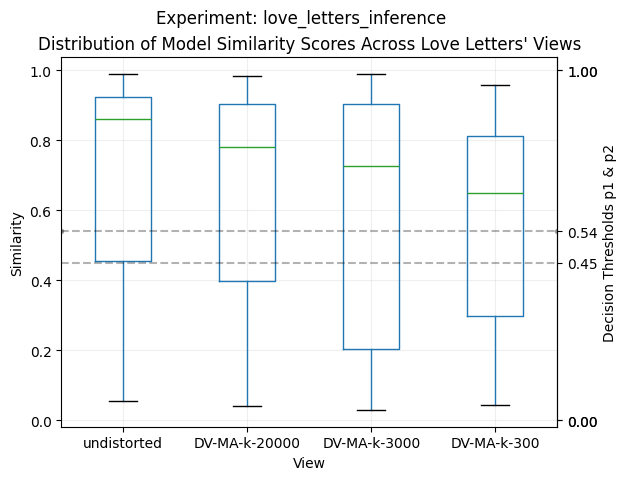

In [17]:
# Adapted from:
# https://stackoverflow.com/a/19736406
df_view_preds = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in view_preds.items()]))
# Adapted from:
# https://stackoverflow.com/a/41968766
df_view_preds = df_view_preds[[
    'undistorted',
    'DV-MA-k-20000',
    'DV-MA-k-3000',
    'DV-MA-k-300'
]]

# Adapted from:
# https://stackoverflow.com/a/23508225
ax = df_view_preds.boxplot(showfliers=True)
ax.set_ylabel('Similarity')
ax.set_xlabel('View')
fig = ax.get_figure()
fig.suptitle('Experiment: love_letters_inference')
ax.set_title("Distribution of Model Similarity Scores Across Love Letters' Views")


# Adapted from:
# https://stackoverflow.com/a/14762601
def id_fn(x):
    return x


ax2 = ax.secondary_yaxis('right', functions=(id_fn, id_fn))
ax2.set_ylabel('Decision Thresholds p1 & p2')

# Adapted from:
# https://stackoverflow.com/a/14716726
extraticks = [0., P1, P2, 1.]
ax2.set_yticks([0,1] + extraticks)
# Adapted from:
# horizontal line indicating the threshold
# https://stackoverflow.com/a/28129801
p2_line, = ax.plot([0.5, 4.5], [P2, P2], "k--.", alpha=0.3)
p1_line, = ax.plot([0.5, 4.5], [P1, P1], "k--", alpha=0.3)

plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show(ax)

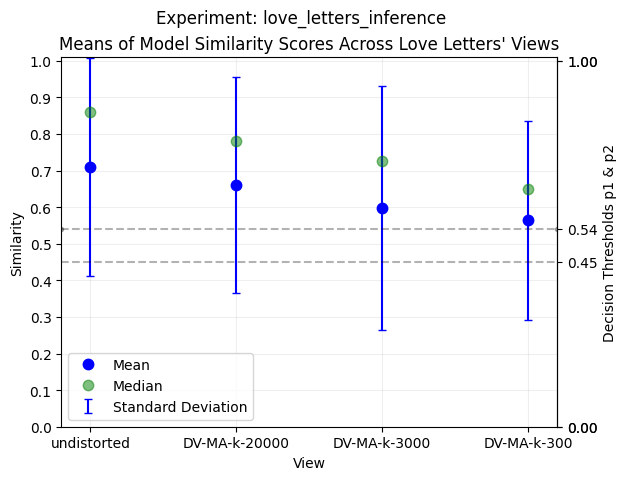

In [16]:
# Adapted from:
# https://stackoverflow.com/a/22482010
ax = plt.errorbar(df_stats.index, 
                  df_stats['mean'],
                  yerr=df_stats['std'],
                  linestyle='None',
                  capsize=3,
                  color='b',
                  label='Standard Deviation')

ax = plt.gca()
ax.set_yticks(np.arange(0.0, 1.1, 0.1))
ax.set_ylabel('Similarity')
ax.set_xlabel('View')

fig = ax.get_figure()
fig.suptitle('Experiment: love_letters_inference')
ax.set_title("Means of Model Similarity Scores Across Love Letters' Views")

plt.plot(df_stats.index,
         df_stats['mean'],
         linestyle='None', 
         marker='.',
         markersize=15,
         color='b',
         label='Mean')
median_line = plt.plot(df_stats.index,
                       df_stats['median'],
                       linestyle='None',
                       marker='.',
                       markersize=15,
                       color='g',
                       alpha=0.5,
                       label='Median')

# Adapted from:
# https://stackoverflow.com/a/14762601
def id_fn(x):
    return x
ax2 = ax.secondary_yaxis('right', functions=(id_fn, id_fn))
ax2.set_ylabel('Decision Thresholds p1 & p2')

# Adapted from:
# https://stackoverflow.com/a/14716726
extraticks = [0., P1, P2, 1.]
ax2.set_yticks([0,1] + extraticks)
# Adapted from:
# horizontal line indicating the threshold
# https://stackoverflow.com/a/28129801
p2_line, = ax.plot([-0.2, 3.2], [P2, P2], "k--.", alpha=0.3)
p1_line, = ax.plot([-0.2, 3.2], [P1, P1], "k--", alpha=0.3)

plt.xlim(-0.2,3.2)
plt.ylim(0.,1.01)

plt.legend()

plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show(ax)

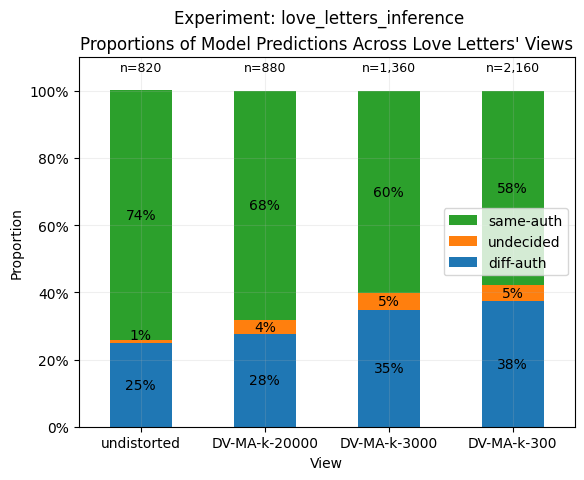

In [18]:
preds_ratios = df_stats[['diff-auth','same-auth','undecided']]
preds_ratios = preds_ratios[['diff-auth','undecided','same-auth']]
preds_ratios = preds_ratios * 100
ax = preds_ratios.plot.bar(stacked=True)

totals = df_stats['num preds']

# Adapted from:
# https://stackoverflow.com/a/75212900
# ax = per.plot(kind='bar', stacked=True, figsize=(8, 6), rot=0)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    va = 'bottom' if height < 4 else 'center'
    ax.text(x+width/2, 
        y+height/2, 
        f'{height:.0f}%', 
        horizontalalignment='center', 
        verticalalignment=va)

for i, total in enumerate(totals):
    ax.text(i, 105,
            f'n={int(total):,}',
            horizontalalignment='center',
            verticalalignment='bottom',
            fontsize=9)

ax.set_ylabel('Proportion')
ax.set_xlabel('View')

ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_ylim(0, 110)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

fig = ax.get_figure()
fig.suptitle('Experiment: love_letters_inference')
ax.set_title("Proportions of Model Predictions Across Love Letters' Views")
# Adapted from:
# https://stackoverflow.com/a/37708190
plt.xticks(rotation=0)
plt.legend(reverse=True)

plt.grid(True, which="both", ls="-", alpha=0.2)

plt.show(ax)

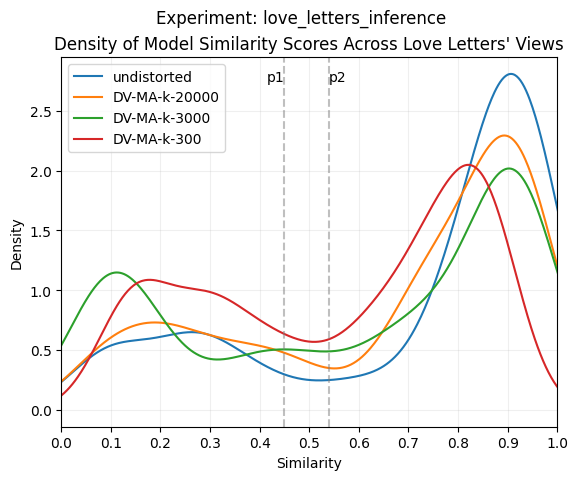

In [19]:
ax = df_view_preds.plot.density()
ax.set_xticks(np.arange(0.0, 1.1, 0.1))
plt.xlim(0.0, 1.0)

plt.axvline(x=P1, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=P2, color='gray', linestyle='--', alpha=0.5)

plt.text(P1, plt.ylim()[1] - 0.2, 'p1', rotation=0, horizontalalignment='right')
plt.text(P2, plt.ylim()[1] - 0.2, 'p2', rotation=0, horizontalalignment='left')

ax.set_xlabel('Similarity')

fig = ax.get_figure()
fig.suptitle('Experiment: love_letters_inference')
ax.set_title("Density of Model Similarity Scores Across Love Letters' Views")

plt.grid(True, which="both", ls="-", alpha=0.2)

plt.show(ax)

In [223]:
import random

def convert_pair(p, v):
    anchor_ids = p[0]['input_ids'].squeeze().tolist()[1:-1]
    other_ids = p[1]['input_ids'].squeeze().tolist()[1:-1]

    return [' '.join([v[a_id] for a_id in anchor_ids]),
            ' '.join([v[o_id] for o_id in other_ids])]


df_rep_chunks = pd.DataFrame(columns=[
    'anchor (U)',
    'other (A)',
    'sim',
    'group',
    'view'
])


# Adapted from:
# https://stackoverflow.com/a/19736406
df_view_preds = pd.DataFrame(dict([(k, pd.Series(v))
                                   for k, v in view_preds.items()]))
df_view_embeddings = pd.DataFrame(dict([(k, pd.Series(v))
                                        for k, v
                                        in view_embeddings.items()]))

# Adapted from:
# https://stackoverflow.com/a/41968766
ordering = [
    'undistorted',
    'DV-MA-k-20000',
    'DV-MA-k-3000',
    'DV-MA-k-300'
]

df_view_preds = df_view_preds[ordering]
df_view_embeddings = df_view_embeddings[ordering]

vocab = inference_dataset.tokenizer.vocab

# Swap keys and values to be {id: word} for quicker lookups
# Adapted from:
# https://stackoverflow.com/a/13149770
vocab = {v: k for v, k in zip(list(vocab.values()),
                              list(vocab.keys()))}

low_indexes = {}
abstained_indexes = {}
high_indexes = {}
last_idxs = {}
for view in ordering:
    last_idxs[view] = len(df_view_preds[view].dropna())
    low_mask = df_view_preds[view] < 0.10
    low_indexes[view] = df_view_preds[view][low_mask].index.tolist()
    least_sim_index = df_view_preds[view].idxmin()
    least_sim_embedding = df_view_embeddings[view].iloc[least_sim_index]
    least_sim_sim = df_view_preds[view].iloc[least_sim_index]
    least_sim_nlc = convert_pair(least_sim_embedding, vocab)
    df_rep_chunks.loc[len(df_rep_chunks)] = [
        least_sim_nlc[0],
        least_sim_nlc[1],
        least_sim_sim,
        'low',
        view
    ]
    abstained_mask = (df_view_preds[view] > P1) & (df_view_preds[view] < P2)
    abstained_indexes[view] = df_view_preds[view][abstained_mask].index.tolist()
    random_absention_index = random.sample(abstained_indexes[view], k=1)[0]
    random_absention_embedding = df_view_embeddings[view].iloc[random_absention_index]
    random_absention_sim = df_view_preds[view].iloc[random_absention_index]
    random_absention_nlc = convert_pair(random_absention_embedding, vocab)
    df_rep_chunks.loc[len(df_rep_chunks)] = [
        random_absention_nlc[0],
        random_absention_nlc[1],
        random_absention_sim,
        'abstained',
        view
    ]
    high_mask = df_view_preds[view] > 0.90
    high_indexes[view] = df_view_preds[view][high_mask].index.tolist()
    most_sim_index = df_view_preds[view].idxmax()
    most_sim_embedding = df_view_embeddings[view].iloc[most_sim_index]
    most_sim_sim = df_view_preds[view].iloc[most_sim_index]
    most_sim_nlc = convert_pair(most_sim_embedding, vocab)
    df_rep_chunks.loc[len(df_rep_chunks)] = [
        most_sim_nlc[0],
        most_sim_nlc[1],
        most_sim_sim,
        'high',
        view
    ]

# Write the pairs to JSONL
with open('rep_chunks.jsonl', 'w') as f:
    f.write(df_rep_chunks.to_json(orient='records', lines=True))

df_rep_chunks_grouped = df_rep_chunks.groupby(by='group')

md_txt = '# Representative Chunks Analysis'

for group in df_rep_chunks_grouped:
    md_txt += f"\n\n## SIM PREDICTION: {group[0].upper()}"
    for i, rep_chunk in enumerate(group[1].iterrows()):
        md_txt += f"\n\n### VIEW {rep_chunk[1]['view']}"
        md_txt += f"\n\n`SIMILARITY = {rep_chunk[1]['sim']}`"
        md_txt += "\n\n- ANCHOR (`U`)"
        md_txt += "\n  - **DOC**: ``"
        md_txt += f"\n  - **TXT**: \"_{rep_chunk[1]['anchor (U)']}_\""
        md_txt += "\n- OTHER (`A`)"
        md_txt += "\n  - **DOC**: ``"
        md_txt += f"\n  - **TXT**: \"_{rep_chunk[1]['other (A)']}_\""

with open('rep_chunks_analysis.md', 'w') as f:
    f.write(md_txt)